In [2]:
import sys
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import numpy as np
import SimpleITK as sitk
import radiomics as rad
import six
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

plt.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "black",
                     "patch.facecolor": "white",
                     "figure.facecolor" : "white"}) # prevent the transparency WHEREEVER IT CAME FROM?!

In [3]:
sys.path.append(os.path.abspath('src/'))
from data.lungdataset import LungData
#from utils import extract_firstlevel_features


In [4]:

rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd
image_df = ld.as_dataframe()
#ld.as_dataframe()

print(medical_df.shape, " -- ", image_df.shape)

(1279, 130)  --  (4728, 8)


## Exploration

In [5]:
rdf = pd.read_csv("data/radiomics/thresh1_radiomics_all_stacked.csv")
rdf = ld.prepare_multiclass_for_radiomics(rdf, medical_df, verbose=True)
rdf.head(5)

Labels: ['last.status', 'is_icu', 'was_ventilated'], 
        [0:'000' 1:'001' 2:'010' 3:'011' 4:'100' 5:'101' 6:'110' 7:'111']
3    1669
0    1326
7    1322
4     142
2     134
1     102
6      30
5       3
Name: y, dtype: int64


,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,MeanAbsoluteDeviation_l,Mean_l,Median_l,...,HighGrayLevelEmphasis_r,LargeDependenceEmphasis_r,LargeDependenceHighGrayLevelEmphasis_r,LargeDependenceLowGrayLevelEmphasis_r,LowGrayLevelEmphasis_r,SmallDependenceEmphasis_r,SmallDependenceHighGrayLevelEmphasis_r,SmallDependenceLowGrayLevelEmphasis_r,id,y
0,71.0,150.0,394369086.0,2.394008,41.0,3.095117,218.0,24.855771,113.581023,116.0,...,20.869773,41.678136,840.518399,4.847234,0.110090,0.056541,1.328324,0.005729,A860070,3
1,55.0,149.0,296824858.0,2.539965,50.0,2.468845,194.0,28.485066,104.368473,107.0,...,22.867574,42.255443,937.161292,3.852431,0.087336,0.059224,1.406542,0.005033,A860070,3
2,54.0,161.0,707815625.0,2.702847,57.0,2.444984,211.0,32.624710,111.785194,116.0,...,2.507463,38.208955,86.283582,26.256633,0.639718,0.057139,0.151222,0.037764,A860070,3
3,64.0,155.0,426125614.0,2.510545,48.0,2.926102,215.0,28.382876,115.519975,122.0,...,24.524862,37.920871,942.892160,3.744262,0.094085,0.058552,1.440691,0.005426,A860070,3
4,77.0,171.0,480829393.0,2.587292,51.0,3.016582,224.0,30.056974,129.213178,136.0,...,32.925355,39.206941,1364.961341,2.504407,0.067633,0.058938,1.848536,0.004401,A860070,3


In [6]:
scaler = StandardScaler()
rdfs = scaler.fit_transform(rdf.drop(["id", "y", "xray_path"], axis=1))

rdfs = pd.DataFrame(rdfs, columns = rdf.drop(["id", "y", "xray_path"], axis=1).columns)
#rdfs["left"] = rdf["left"].astype(int)
rdfs.head(5)

,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,MeanAbsoluteDeviation_l,Mean_l,Median_l,...,GrayLevelNonUniformity.2_r,GrayLevelVariance.2_r,HighGrayLevelEmphasis_r,LargeDependenceEmphasis_r,LargeDependenceHighGrayLevelEmphasis_r,LargeDependenceLowGrayLevelEmphasis_r,LowGrayLevelEmphasis_r,SmallDependenceEmphasis_r,SmallDependenceHighGrayLevelEmphasis_r,SmallDependenceLowGrayLevelEmphasis_r
0,1.366156,-0.432888,0.373103,-1.023749,-1.592519,1.713546,0.275278,-1.472579,0.801399,0.829366,...,-0.744035,-0.385462,-0.760326,-0.677136,-0.936106,0.365638,0.471953,0.504692,-0.079741,0.437560
1,0.334936,-0.506453,-0.291590,-0.466352,-0.828620,0.129926,-1.107227,-0.816460,0.110640,0.268347,...,-0.171587,-0.099792,-0.351593,-0.545488,-0.573272,-0.125002,-0.057994,0.807618,0.141933,0.176211
2,0.270485,0.376324,2.509013,0.155678,-0.234477,0.069588,-0.127953,-0.068076,0.666748,0.829366,...,-3.218556,-3.534475,-4.517094,-1.468239,-3.767786,10.924811,12.807181,0.572180,-3.415725,12.458733
3,0.914997,-0.065065,0.589500,-0.578705,-0.998375,1.286165,0.102465,-0.834934,0.946783,1.203379,...,-0.767838,0.238967,-0.012527,-1.533933,-0.551756,-0.178351,0.099194,0.731698,0.238715,0.323788
4,1.752863,1.111971,0.962267,-0.285614,-0.743743,1.514958,0.620904,-0.532283,1.973503,2.076076,...,-0.834801,0.925764,1.706141,-1.240661,1.032850,-0.789851,-0.516898,0.775256,1.394574,-0.060805


In [7]:
corr_thresh = 0.95
corr_matrix = rdfs.corr().abs() # Create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > corr_thresh)] # Find features with correlation greater than 0.95
rdfs_cleaned = rdfs.drop(to_drop, axis=1) # Drop features 
print(to_drop)
print(rdfs_cleaned.shape)

['MeanAbsoluteDeviation_l', 'Median_l', 'RobustMeanAbsoluteDeviation_l', 'RootMeanSquared_l', 'TotalEnergy_l', 'Uniformity_l', 'Variance_l', 'MaximumDiameter_l', 'PixelSurface_l', 'ClusterProminence_l', 'ClusterTendency_l', 'DifferenceEntropy_l', 'DifferenceVariance_l', 'Id_l', 'Idm_l', 'Imc2_l', 'InverseVariance_l', 'JointAverage_l', 'JointEnergy_l', 'MCC_l', 'MaximumProbability_l', 'SumAverage_l', 'SumEntropy_l', 'SumSquares_l', 'ZoneVariance_l', 'GrayLevelNonUniformityNormalized.1_l', 'GrayLevelVariance.1_l', 'HighGrayLevelRunEmphasis_l', 'RunPercentage_l', 'RunVariance_l', 'ShortRunEmphasis_l', 'DependenceEntropy_l', 'DependenceNonUniformity_l', 'GrayLevelVariance.2_l', 'HighGrayLevelEmphasis_l', 'LargeDependenceEmphasis_l', 'LowGrayLevelEmphasis_l', 'SmallDependenceEmphasis_l', 'MeanAbsoluteDeviation_r', 'Median_r', 'RobustMeanAbsoluteDeviation_r', 'RootMeanSquared_r', 'TotalEnergy_r', 'Variance_r', 'MaximumDiameter_r', 'PixelSurface_r', 'ClusterProminence_r', 'ClusterTendency_r',

In [8]:
rdfs_cleaned["to_patient_id"] = rdf["id"]

rdfs_targets = rdfs_cleaned.merge(medical_df[ld._targets + ["to_patient_id"]], how="outer", on="to_patient_id") # merge with targets
rdfs_targets[ld._targets] = rdfs_targets[ld._targets].replace({"discharged": 0, "deceased": 1,
    True:1, False:0, "Yes":1, "No":0}) # replace targets like done so many times before

ml_df = ld.ml_target_df # get pretty labels
ml_df["to_patient_id"] = medical_df["to_patient_id"] # merge pretty labels with patient ids
rdfs_targets = rdfs_targets.merge(ml_df, how="outer", on="to_patient_id") # merge with target dataframe
rdfs_targets = pd.concat([rdfs_targets, pd.get_dummies(rdfs_targets["Outcome"])], axis=1) # one-hot encode pretty labels
rdfs_targets.drop(["to_patient_id", "labelstring", "y", "Outcome"], axis=1, inplace=True) # drop unnec. cols
print(rdfs_targets.shape)
rdfs_targets


(4728, 142)


,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,Mean_l,Minimum_l,Range_l,...,is_icu,was_ventilated,Deceased,Deceased + ICU,Deceased + ICU + Ventilated,Deceased + Ventilated,Hospitalized (only),ICU,ICU + Vent,Ventilated
0,1.366156,-0.432888,0.373103,-1.023749,-1.592519,1.713546,0.275278,0.801399,0.375685,-0.019925,...,1,1,0,0,0,0,0,0,1,0
1,0.334936,-0.506453,-0.291590,-0.466352,-0.828620,0.129926,-1.107227,0.110640,-0.050186,-0.717465,...,1,1,0,0,0,0,0,0,1,0
2,0.270485,0.376324,2.509013,0.155678,-0.234477,0.069588,-0.127953,0.666748,-0.405080,0.135084,...,1,1,0,0,0,0,0,0,1,0
3,0.914997,-0.065065,0.589500,-0.578705,-0.998375,1.286165,0.102465,0.946783,-0.263122,0.212588,...,1,1,0,0,0,0,0,0,1,0
4,1.752863,1.111971,0.962267,-0.285614,-0.743743,1.514958,0.620904,1.973503,-0.121165,0.483854,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,-0.631832,-0.212194,-0.485353,0.373007,0.105033,-0.256749,0.160069,-0.185279,-0.547037,0.406349,...,0,0,0,0,0,0,1,0,0,0
4724,-0.309576,-0.285759,0.158176,0.184741,0.189911,-0.529834,0.332882,-0.321564,-0.263122,0.367597,...,0,0,0,0,0,0,1,0,0,0
4725,-0.180673,0.817712,0.864294,0.594591,0.529421,-0.385389,0.793717,0.030179,-0.121165,0.600110,...,0,0,0,0,0,0,1,0,0,0
4726,-1.018539,0.229194,0.143001,0.752451,0.699176,-0.549719,0.275278,-0.663898,-0.618016,0.522606,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

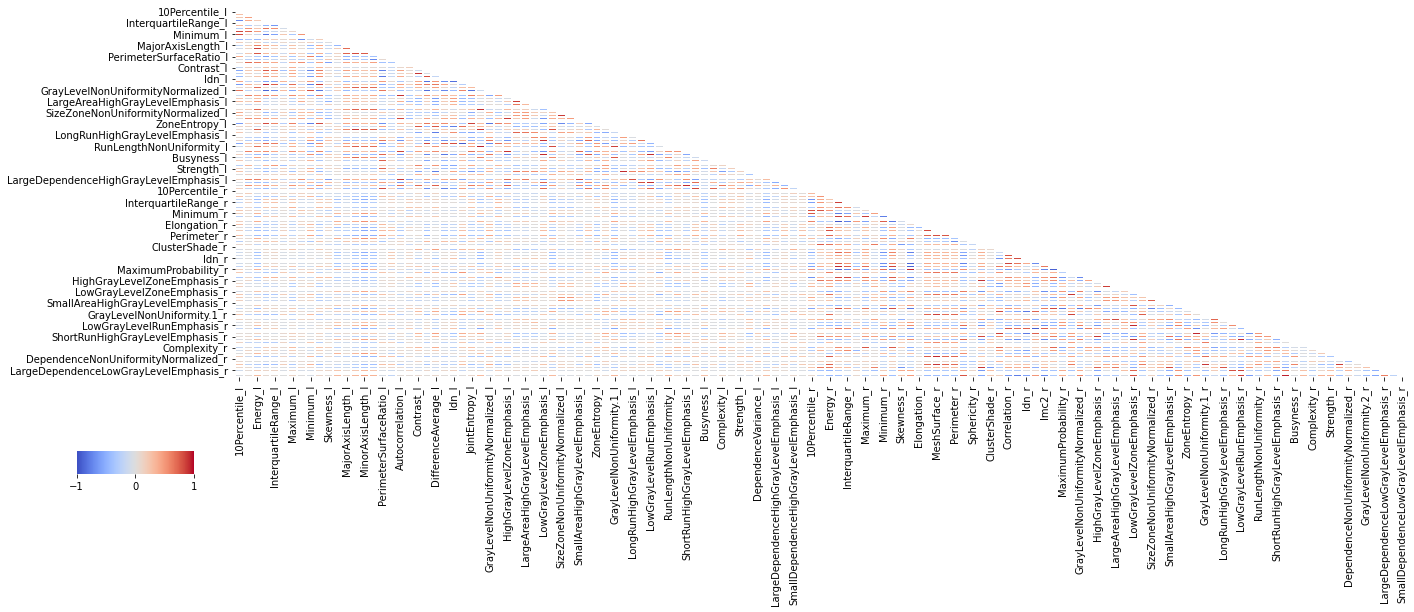

In [9]:
#fig, ax = plt.subplots(2,1, figsize=(24,12))
plt.figure(figsize=(21,9))

cdf = rdfs_cleaned.corr()
mask = np.zeros_like(cdf)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(rdfs_cleaned.corr(), vmin=-1, vmax=1,
#        square=True, 
        cmap="coolwarm",
        linewidths=0.005,
        cbar_kws={"orientation": "horizontal", "location": "bottom",
        "fraction": 0.1, "aspect":5, "shrink":0.1,
        "anchor": (-0.15,1)},
        mask=mask
        #linewidths=0.01
        #cmap = "coolwarm"
)
#plt.xticks(rotation=45)


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
         63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
         72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
         81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
         90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
         99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
        108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
        117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
      

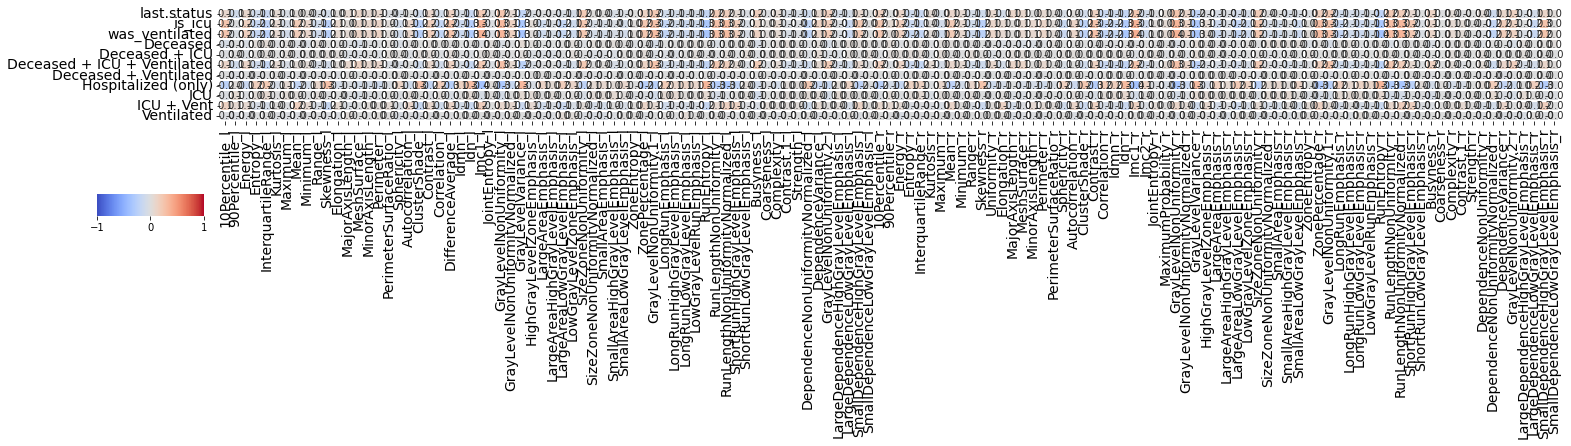

In [10]:
targets = ld._targets + list(rdfs_targets.columns[-8:])

plt.figure(figsize=(24,9))
sns.heatmap(rdfs_targets.corr()[targets].T.iloc[:,:-11],
    square=True,
    vmax=1, vmin=-1,
    annot=True,
    fmt=".1f",
    linewidths=0.01, 
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"orientation": "horizontal", "location": "bottom",
        "fraction": 0.1, "aspect":5, "shrink":0.08,
        "anchor": (-0.1, 1)},
)
#plt.title("Radiomics Features correlation with prediction targets", size=16)
plt.yticks(size=14)
plt.xticks(size=14)


In [11]:
ld.ml_target_df["Outcome"].value_counts()

Hospitalized (only)            948
Deceased + ICU + Ventilated    100
ICU + Vent                     100
Deceased                        61
ICU                             46
Deceased + ICU                  11
Ventilated                      11
Deceased + Ventilated            2
Name: Outcome, dtype: int64

We can see that the features do explain the targets slightly. Less explainability is achieved in the under-represented classes (Deceased, Ventilated, Deceased + Vent, Deceased + ICU). Other correlate more, with a contradictory effect for some targets, which makes sense. 

---
### Metrics

Which metrics are good fits to report now? 

- __Accuracy__ (for completeness because Li et al. use them)
- __Balanced accuracy__ for relation of sensitivity (true positive rate == recall) + specificity (true negative rate). How is my overall accuracy based on True positive and true negative predictions?
- __F1 score__, harmonic mean between precision and recall (micro, ovr). 
- __ROC/AUC__, FPR and TPR(recall) 

What we want is a high __specifitiy__ per class, so an overall high specifitiy is most important. 


Li et al:
- Accuracy
- Specificity (true negative rate) 
- Sensitivity (recall, true positive rate)
- ROC-AUC

Zhao et al:
- ROC-AUC

---
## Prediction

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_absolute_error, balanced_accuracy_score, f1_score, accuracy_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline as Pipeline_sampler

random_state = 42
rnd_state = random_state

In [13]:
#X = rdfs_cleaned.drop("to_patient_id", axis=1) # scaled and cleaned from correlated features
#y = rdf["y"]

y = rdf["y"].copy()
X = rdf.drop(to_drop, axis=1).drop(["id", "y", "xray_path"], axis=1)
y.value_counts()
# It will not make sense to use the 5-label pictures, we just set them to 7 instead (from deceased + ventilated -> deceased + vent + icu)
y[y==5] = 7
y.value_counts()

3    1669
0    1326
7    1325
4     142
2     134
1     102
6      30
Name: y, dtype: int64

In [14]:
# stratified split raw data to keep the original distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                   random_state=random_state, stratify=y, 
                                   )

res = pd.DataFrame() # dataframe for saving all the results
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3309, 131) (3309,)
(1419, 131) (1419,)


In [15]:
X_train.head()

,10Percentile_l,90Percentile_l,Energy_l,Entropy_l,InterquartileRange_l,Kurtosis_l,Maximum_l,Mean_l,Minimum_l,Range_l,...,Contrast.1_r,Strength_r,DependenceNonUniformity_r,DependenceNonUniformityNormalized_r,DependenceVariance_r,GrayLevelNonUniformity.2_r,LargeDependenceHighGrayLevelEmphasis_r,LargeDependenceLowGrayLevelEmphasis_r,SmallDependenceHighGrayLevelEmphasis_r,SmallDependenceLowGrayLevelEmphasis_r
3725,62.0,148.0,359369272.0,2.465969,48.0,2.538103,205.0,105.663086,16.0,189.0,...,0.020983,0.027196,4277.698567,0.142244,4.174552,4603.456689,1053.747381,3.837367,1.378684,0.004853
1086,65.0,158.0,435659711.0,2.442512,54.0,2.306543,190.0,116.952643,24.0,166.0,...,0.020547,0.008885,6004.992693,0.158976,4.409053,8254.686231,1297.213565,2.630370,1.361867,0.003098
4026,46.0,152.0,386659498.0,2.732063,55.0,2.692775,244.0,98.442104,9.0,235.0,...,0.015567,0.023224,5495.408463,0.143889,4.228231,6805.424539,816.146156,5.415724,1.074965,0.005150
3197,51.0,155.0,428862699.0,2.534916,60.0,2.405641,222.0,114.751144,11.0,211.0,...,0.023084,0.015343,4963.524891,0.138198,4.558474,5961.884508,1206.285778,2.863243,1.599837,0.004295
4416,41.0,150.0,313788686.0,2.759235,63.0,2.309250,213.0,94.893775,3.0,210.0,...,0.017053,0.027585,6174.569453,0.168107,4.097221,5865.584536,1124.486088,4.924965,0.990711,0.004357


In [16]:
from src.rad_classification.prediction import classify, classify_imbalanced
_k = 10 # how many folds

In [17]:
## None
_res = classify(X_train, y_train, k_fold=_k)
_res["method"] = "None"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## balanced-weights
_res = classify(X_train, y_train, class_weights="balanced", k_fold=_k)
_res["method"] = "Balanced-Weights"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:13:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:04] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:13:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:23] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

[16:15:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:17] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:15:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:31] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

### Over/Undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_sampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

random_state = 42
rnd_state = random_state

In [19]:
## rus
_res = classify_imbalanced(X_train, y_train, sampler=RandomUnderSampler(random_state=rnd_state), k_fold=_k)
_res["method"] = "Random-Undersampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## ros
_res = classify_imbalanced(X_train, y_train, sampler=RandomOverSampler(random_state=rnd_state), k_fold=_k)
_res["method"] = "Random-Oversampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## SMOTE
_res = classify_imbalanced(X_train, y_train, sampler=SMOTE(random_state=rnd_state), k_fold=_k)
_res["method"] = "SMOTE"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:50] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[16:19:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:29] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:19:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:51] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

[16:24:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:23] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[16:24:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:59] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [20]:
res_table = res.filter(regex="mean_test").drop(('Balanced-Weights', 'xgboost')).round(3)
_metrics = ["Accuracy", "Balanced-Accuracy", "ROC-AUC", "Recall"] 
res_table.columns=_metrics
res_std_table = res.filter(regex="std_test").drop(('Balanced-Weights', 'xgboost')).round(3)
res_std_table.columns=_metrics
res_table_string = res_table[_metrics].astype(str) + "\n +/-" + res_std_table[_metrics].astype(str)
#res_table_string
#print(res_table_string.T.to_latex(caption="Test", label="tab:results"))

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


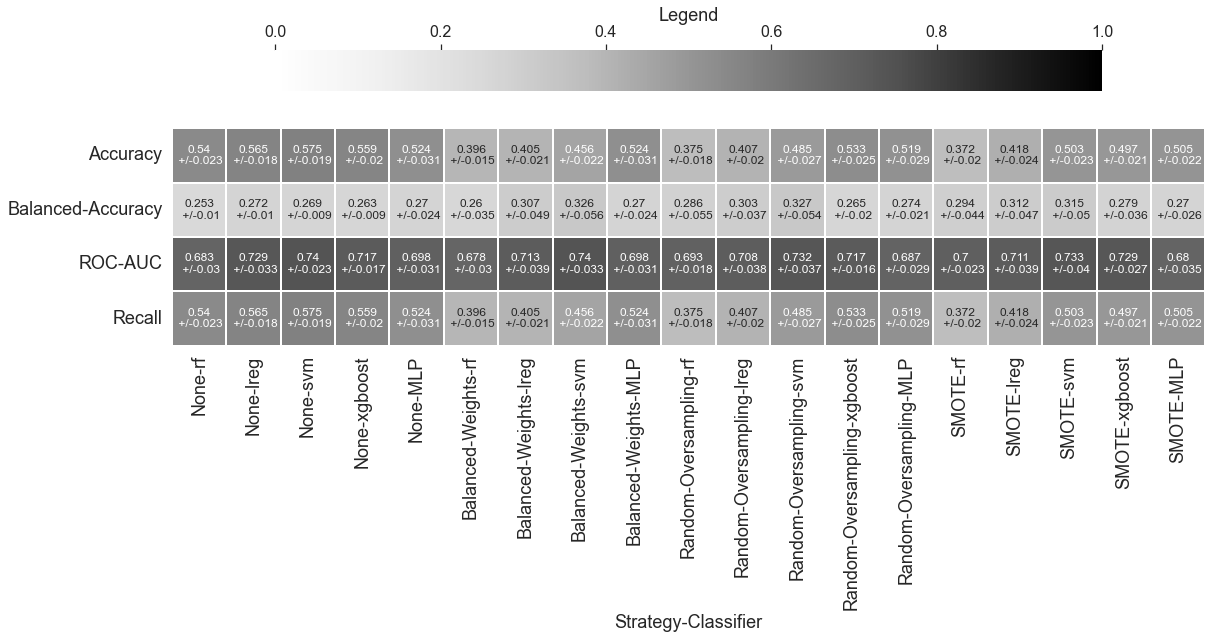

In [39]:
sns.set_theme(style="whitegrid", font_scale=1.)

fig, ax = plt.subplots(1,1, figsize=(17,11), #sharex=True
)
fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
g = sns.heatmap(res_table.T.drop("Random-Undersampling", axis=1), square=True, linewidth=0.05,
            cmap="Greys", vmin=0.0, vmax=1.0,
            annot = res_table_string.T.drop("Random-Undersampling", axis=1), fmt="", cbar=True,
            # annot=True, fmt=".3f", cbar=False
            cbar_kws={"orientation": "horizontal", "location": "top",
            "label":"Legend",
            "fraction": 0.1,
            #"aspect":5, 
            "shrink":0.8,
            #"anchor": (0.1, 1.1)
            },
        )

g.set(xlabel="", ylabel="", aspect="equal")
#g.despine(left=True, bottom=True)
g.set_xlabel("Strategy-Classifier", fontsize=18)
for label in g.get_yticklabels():
    label.set_fontsize(18)
for label in g.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
ax.figure.axes[-1].xaxis.label.set_size(18)

fig.tight_layout()
#print(res.T.to_latex())
fig.savefig("../thesis/figures/results/radiomics/classifier_results.png",)# dpi=180)
sns.set_theme(style="whitegrid", font_scale=1.)

Looks like SMOTE + SVM is the most promising one. MLP tend to overfit and the rest is worse than SVM over nearly all metrics. Oversampling did only marginally improve things while undersampling had nearly no positive impact. XGBoost would be a natural 2nd place. Lets see how the best ones perform in CV setting/tune for hyperparams.

1. SMOTE+SVM
2. Balanced weights SVM (low complexity)
3. SMOTE+XGBoost

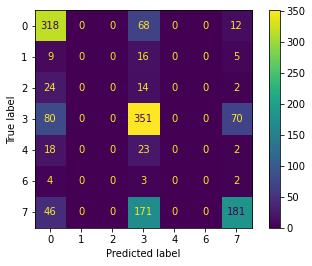

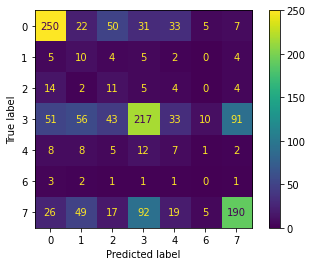

In [ ]:
classifiers = [('svm', SVC(probability=True, random_state=rnd_state)),
                ('svm', SVC(probability=True, class_weight="balanced", random_state=rnd_state)),]
cms = []

Xt_train, yt_train, Xt_test, yt_test = train_test_split(X_train, y_train, test_size=0.1,
                                                        random_state=random_state, stratify=y_train)

for c in classifiers:
    pipe = Pipeline([('scaler', StandardScaler()),
                #('pca', PCA(n_components=0.95)),
                c])
    pipe.fit(Xt_train, yt_train)
    cms.append(ConfusionMatrixDisplay.from_estimator(pipe, Xt_test, yt_test))


---
## CV

In [75]:
# remove some images that we will keep out and enable for user upload/testing :-)
_X = rdf.drop(to_drop, axis=1)#.drop(["id", "y", "xray_path"], axis=1)
X_full, x_left_out, y_full, y_left_out = train_test_split(_X, y, test_size=0.002, random_state=10)
print(X_full.shape, x_left_out.shape)
print(y_full.shape, y_left_out.shape)

X_full = X_full.drop(["id", "y", "xray_path"], axis=1, errors="ignore")


(4718, 134) (10, 134)
(4718,) (10,)


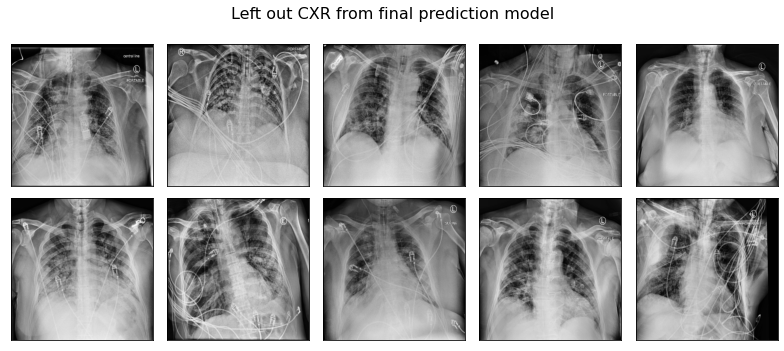

In [65]:
def _load_image(input:str):
    img = imread(input)
    img = Image.fromarray(img).convert("P")
    img = torchvision.transforms.functional.resize(img, (512, 512))
    return img

paths = x_left_out.xray_path.values
#print(paths)
fig, ax = plt.subplots(2,5,figsize=(11,5), sharex=True, sharey=True)
for _row in range(0,2):
    for _col in range(0,5):
        ax[_row, _col].imshow(_load_image(paths[5*_row+_col]))
        ax[_row, _col].set_xticks([])
        ax[_row, _col].set_yticks([])
fig.suptitle("Left out CXR from final prediction model", size=16)
fig.tight_layout()
fig.savefig("../thesis/figures/left_out_xrays.png")

In [81]:
import joblib
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]
# smote+xg

results = pd.DataFrame()

for REFIT in REFITs:
    print(REFIT)
    pipe_svm = Pipeline_sampler([("sc", StandardScaler()),
                ("svc", SVC(probability=True, class_weight="balanced")),
                ])

    p_svm = {
        "svc__random_state" : [0, 42, 420, 64532],
        "svc__class_weight" : ["balanced"],
        "svc__C" : [0.01, 0.1, 0.25, 0.5, 0.75,
                    1, 1.5, 3, 5, 10,
                    15, 25, 30],
        "svc__kernel": ["rbf", "poly", "linear"],
        "svc__decision_function_shape": ["ovo"],
    }

    scoring = { 'accuracy': make_scorer(accuracy_score),
                'balanced_accuracy': make_scorer(balanced_accuracy_score),
                'f1_weighted': make_scorer(f1_score, average = 'weighted'),
                'roc_auc': make_scorer(roc_auc_score, multi_class="ovo", needs_proba=True, average="weighted"),
                'recall': make_scorer(recall_score, average = 'weighted'),
            }

    gscv = GridSearchCV(pipe_svm, p_svm,
        scoring=scoring, cv=_k, n_jobs=4, refit=REFIT)
    gscv.fit(X_train, y_train)
    gsres = pd.DataFrame(gscv.cv_results_)

    best_model = gscv.best_estimator_
    print(best_model)

    _roc = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["mean_test_roc_auc"]
    _roc_std = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["std_test_roc_auc"]
    print("cv-train {}: {} +/- {:.3f}".format(REFIT, _roc, _roc_std*1.96))

    if not os.path.isfile(f"models/radiomics/svm_{REFIT}.pkl"):
        joblib.dump(best_model, f"models/radiomics/svm_{REFIT}.pkl")
        joblib.dump(best_model.fit(X_full,y_full), f"models/radiomics/svm_{REFIT}_trained_on_all.pkl")
    else:
        best_model = joblib.load(f"models/radiomics/svm_{REFIT}.pkl")

accuracy
Pipeline(steps=[('sc', StandardScaler()),
                ('svc',
                 SVC(C=30, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train accuracy: 0.747 +/- 0.063
balanced_accuracy
Pipeline(steps=[('sc', StandardScaler()),
                ('svc',
                 SVC(C=1.5, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train balanced_accuracy: 0.747 +/- 0.063
recall
Pipeline(steps=[('sc', StandardScaler()),
                ('svc',
                 SVC(C=30, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train recall: 0.747 +/- 0.063
roc_auc
Pipeline(steps=[('sc', StandardScaler()),
                ('svc',
                 SVC(C=3, class_weight='balanced',
                     decision_function_shape

## Eval

In [45]:
from src.ehd_classification.prediction import compute_metrics
import joblib
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]

final_results = pd.DataFrame()
cms = []
for REFIT in REFITs:
    print(f"{REFIT}:    ")
    model = joblib.load(f"models/radiomics/svm_{REFIT}.pkl")
    
    r1, r2, cm = compute_metrics(model, X_train, y_train, X_val, y_val, index=REFIT)
    cms.append(cm)
    final_results = final_results.append(r1)
    print(r2)
    if REFIT=="roc_auc":
        print(r2.T.to_latex())
    print("")
final_results

accuracy:    
                              0      1      2      3      4      6      7
TPR-Sensitivity (recall)  0.756  0.233  0.000  0.603  0.070  0.000  0.548
TNR-Specificity           0.832  0.975  0.977  0.807  0.984  0.998  0.856

balanced_accuracy:    
                              0      1      2      3      4      6      7
TPR-Sensitivity (recall)  0.656  0.300  0.225  0.455  0.140  0.000  0.500
TNR-Specificity           0.879  0.914  0.920  0.839  0.944  0.991  0.886

recall:    
                              0      1      2      3      4      6      7
TPR-Sensitivity (recall)  0.756  0.233  0.000  0.603  0.070  0.000  0.548
TNR-Specificity           0.832  0.975  0.977  0.807  0.984  0.998  0.856

roc_auc:    
                              0      1      2      3      4      6      7
TPR-Sensitivity (recall)  0.678  0.300  0.175  0.477  0.116  0.000  0.533
TNR-Specificity           0.870  0.928  0.934  0.837  0.946  0.995  0.881
\begin{tabular}{lrr}
\toprule
{} &  TPR-Sensiti

,F1,Accuracy,Balanced Accuracy,Recall,ROC-AUC
accuracy,0.579,0.586,0.316,0.586,0.775
balanced_accuracy,0.536,0.502,0.325,0.502,0.771
recall,0.579,0.586,0.316,0.586,0.775
roc_auc,0.549,0.523,0.326,0.523,0.776


In [48]:
print(cms[3])

_cm = cms[3]

_cm.columns = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.index = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.to_markdown()

                        Hospitalized  Vent  ICU  ICU + Vent.  Deceased  \
Hospitalized                     270    13   32           41        29   
Vent                               5     9    4            5         2   
ICU                               18     3    7            7         2   
ICU + Vent.                       60    43   38          239        24   
Deceased                          12     6    3           10         5   
Deceased + ICU                     5     1    1            0         0   
Deceased + ICU + Vent.            33    34   13           87        17   

                        Deceased + ICU  Deceased + ICU + Vent.  
Hospitalized                         1                      12  
Vent                                 0                       5  
ICU                                  0                       3  
ICU + Vent.                          4                      93  
Deceased                             0                       7  
Deceased + ICU   

'|                        |   Hospitalized |   Vent |   ICU |   ICU + Vent. |   Deceased |   Deceased + ICU |   Deceased + ICU + Vent. |\n|:-----------------------|---------------:|-------:|------:|--------------:|-----------:|-----------------:|-------------------------:|\n| Hospitalized           |            270 |     13 |    32 |            41 |         29 |                1 |                       12 |\n| Vent                   |              5 |      9 |     4 |             5 |          2 |                0 |                        5 |\n| ICU                    |             18 |      3 |     7 |             7 |          2 |                0 |                        3 |\n| ICU + Vent.            |             60 |     43 |    38 |           239 |         24 |                4 |                       93 |\n| Deceased               |             12 |      6 |     3 |            10 |          5 |                0 |                        7 |\n| Deceased + ICU         |              

---

In [53]:
REFIT = "balanced_accuracy"
pipe_svm = Pipeline_sampler([("sc", StandardScaler()),
                # ('imp', KNNImputer()),
                # ("sc2", StandardScaler()),
                ("svc", SVC(probability=True, class_weight="balanced")),
                ])

p_svm = {
    "svc__random_state" : [0, 42, 420, 64532],
    "svc__class_weight" : ["balanced"],
    "svc__C" : [0.01, 0.1, 0.25, 0.5, 0.75,
                1, 1.5, 3, 5, 10,
                15, 25, 30],
    "svc__kernel": ["rbf", "poly", "linear"],
    "svc__decision_function_shape": ["ovo"],
}

scoring = { 'accuracy': make_scorer(accuracy_score),
            'balanced_accuracy': make_scorer(balanced_accuracy_score),
            'f1_weighted': make_scorer(f1_score, average = 'weighted'),
            'roc_auc': make_scorer(roc_auc_score, multi_class="ovo", needs_proba=True, average="weighted"),
            'recall': make_scorer(recall_score, average = 'weighted'),
        }

gscv = GridSearchCV(pipe_svm, p_svm,
        scoring=scoring, cv=_k, n_jobs=4, refit=REFIT)
gscv.fit(X_train, y_train)
gsres = pd.DataFrame(gscv.cv_results_)

best_model = gscv.best_estimator_

In [54]:
gsres.filter(regex="mean_test|params").sort_values(by=["mean_test_balanced_accuracy", "mean_test_roc_auc"], ascending=False)[:5]

,params,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_f1_weighted,mean_test_roc_auc,mean_test_recall
74,"{'svc__C': 1.5, 'svc__class_weight': 'balanced...",0.475981,0.331686,0.509836,0.743146,0.475981
72,"{'svc__C': 1.5, 'svc__class_weight': 'balanced...",0.475981,0.331686,0.509836,0.742680,0.475981
75,"{'svc__C': 1.5, 'svc__class_weight': 'balanced...",0.475981,0.331686,0.509836,0.742455,0.475981
73,"{'svc__C': 1.5, 'svc__class_weight': 'balanced...",0.475981,0.331686,0.509836,0.742185,0.475981
50,"{'svc__C': 0.75, 'svc__class_weight': 'balance...",0.447267,0.326304,0.489315,0.739258,0.447267


In [55]:
print(best_model)

Pipeline(steps=[('sc', StandardScaler()),
                ('svc',
                 SVC(C=1.5, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])


In [56]:
_roc = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["mean_test_roc_auc"]
_roc_std = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["std_test_roc_auc"]
print("ROC_auc: {} +/- {:.3f}".format(_roc, _roc_std*1.96))

ROC_auc: 0.747 +/- 0.063


In [59]:
import joblib
if not os.path.isfile(f"models/radiomics/stacked/final/svm_{REFIT}.pkl"):
    joblib.dump(best_model, f"models/radiomics/stacked/final/svm_{REFIT}.pkl")
else:
    best_model = joblib.load(f"models/radiomics/stacked/final/svm_{REFIT}.pkl")

In [60]:
y_hat = best_model.fit(X_train, y_train).predict(X_val)

print("F1:      {:.3f}".format(f1_score(y_val, y_hat, average="weighted")))
print("Acc:     {:.3f}".format(accuracy_score(y_val, y_hat)))
print("Bal_acc: {:.3f}".format(balanced_accuracy_score(y_val, y_hat)))
print("Recall:  {:.3f}".format(recall_score(y_val, y_hat, average="weighted")))
print("ROC-AUC: {:.3f}".format(roc_auc_score(y_val, best_model.predict_proba(X_val), multi_class="ovo", average="weighted")))

F1:      0.536
Acc:     0.502
Bal_acc: 0.325
Recall:  0.502
ROC-AUC: 0.771


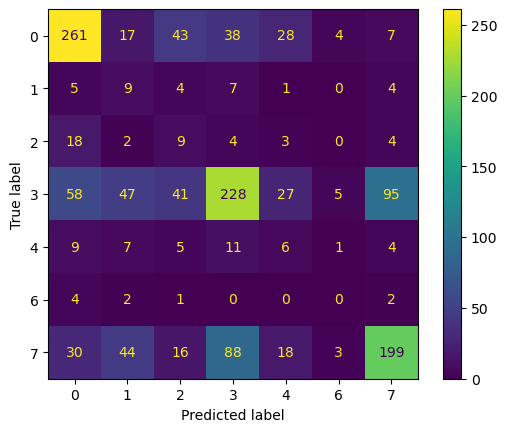

In [63]:
plt.rcdefaults()
cm = confusion_matrix(y_val, best_model.fit(X_train, y_train).predict(X_val))
ConfusionMatrixDisplay.from_predictions(y_val, y_hat)

In [64]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
print(f"{REFIT}")
print(f"TPR - Sensitivity: {TPR}")
print(f"TNR - Specificity: {TNR}")
#print(ACC)
#print(ACC.mean())

balanced_accuracy
TPR - Sensitivity: [0.65577889 0.3        0.225      0.45508982 0.13953488 0.
 0.5       ]
TNR - Specificity: [0.87855044 0.91432685 0.92023205 0.83877996 0.9440407  0.99078014
 0.8863859 ]
